# 分析
切り出したショットデータを取得し、分析します。  
以下は特定ショットのデータを取得/確認し、特徴点（荷重開始点/最大荷重点/破断点）を抽出、その後全ショットから特徴点を抽出するサンプルコードです。抽出した特徴点はElasticsearchに格納されます。

In [1]:
# ライブラリインポート
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../src/'))
from data_reader.data_reader import DataReader
from elastic_manager.elastic_manager import ElasticManager
sys.path.append(os.path.join(os.getcwd(), '../src/analyze/'))
from analyze.h_one_extract_features import *
from analyze.analyze import *

Loading BokehJS ...

In [2]:
# ログ設定
LOG_FILE = os.path.join(
    common.get_config_value(common.APP_CONFIG_PATH, "log_dir"), "analyze/analyze.log"
)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.handlers.RotatingFileHandler(
            LOG_FILE, maxBytes=common.MAX_LOG_SIZE, backupCount=common.BACKUP_COUNT
        ),
        logging.StreamHandler(),
    ],
)

In [3]:
# ショットデータインデックス一覧
ElasticManager.show_indices(index="shots-*-data")

,index,docs.count,store.size
0,shots-20201201010000-data,9356061,1178983
1,shots-20210101000000-data,4040,751
2,shots-20210327141514-data,13586763,1888984


In [4]:
# 対象データ設定
#target = "20201201010000"
target = "20210327141514"
shots_data_index = "shots-" + target + "-data"
shots_meta_index = "shots-" + target + "-meta"

# 1ショットで特徴点抽出

## ショット1番を取得して確認

In [5]:
dr = DataReader()

shot_number = 1229
shot_df = dr.read_shot(shots_data_index, shot_number=shot_number)
shot_df.head()

,timestamp,sequential_number,sequential_number_by_shot,rawdata_sequential_number,displacement,load01,load02,load03,load04,shot_number,tags
0,1.616791e+09,5260537,0,178246387,48.88625,0.019,0.015,-0.014,-0.014,1229,[]
1,1.616791e+09,5260538,1,178246388,48.88625,0.015,0.012,-0.020,-0.017,1229,[]
2,1.616791e+09,5260539,2,178246389,48.88625,0.013,0.008,-0.026,-0.021,1229,[]
3,1.616791e+09,5260540,3,178246390,48.88625,0.014,0.005,-0.030,-0.030,1229,[]
4,1.616791e+09,5260541,4,178246391,48.88625,0.014,0.002,-0.036,-0.035,1229,[]


In [6]:
# ショットメタデータを確認
shots_meta_df = dr.read_shots_meta(shots_meta_index)
shots_meta_df.head()

,shot_number,spm,num_of_samples_in_cut_out
0,1,50.847458,109404.0
1,2,NaN,16564.0
2,3,28.571429,9877.0
3,4,32.608696,8640.0
4,5,35.928144,7798.0


In [7]:
# ショットの数を確認
print(f"ショット数：{len(shots_meta_df)}")

ショット数：3260


In [8]:
pd.set_option('display.max_rows', 3300)
shots_meta_df[shots_meta_df.spm > 80]

,shot_number,spm,num_of_samples_in_cut_out
981,982,400.000000,3878.0
1366,1368,400.000000,3866.0
1377,1380,461.538462,3896.0
2889,2893,428.571429,3840.0


In [ ]:
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

step = 300
for i in range(0, 3300, step):
    x = shots_meta_df.shot_number[i:i+step]
    y = shots_meta_df.spm[i:i+step]
    plt.xlabel("shot_number")
    plt.ylabel("spm")
#    fig = plt.figure()
    plt.plot(x, y)
    plt.show()
#    plt.savefig(f"shots-{i}-{i+step}")

In [9]:
# spm
spm = shots_meta_df[shots_meta_df.shot_number == 1].spm
print(f"spm：{spm}")

spm：0    50.847458
Name: spm, dtype: float64


## 特徴点抽出
1ショットから最大荷重点、荷重開始点、破断点を取得します。  

***shot_data***: 対象ショットデータ  
***spm***: spm  
***func***：適用するロジック  
***sub_func***：サブロジック  
***disp_chart***: グラフ表示

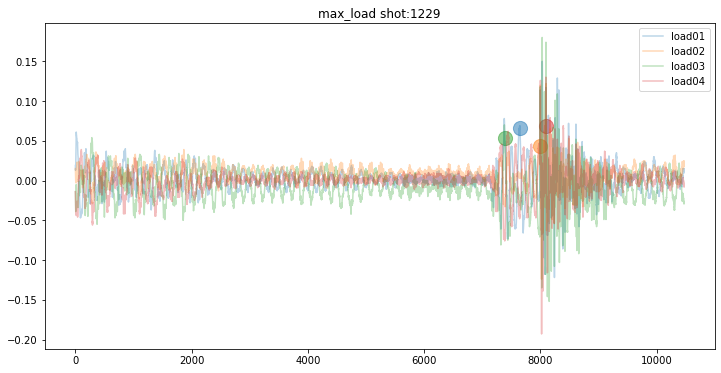

2021-04-07 17:12:58,769 [INFO] NumExpr defaulting to 8 threads.


ValueError: attempt to get argmin of an empty sequence

In [10]:
# 最初のショットの最大荷重点、荷重開始点、破断点を確認
max_load_indicies, max_load_values, debug_values = extract_features(shot_data=shot_df, spm=spm, func=max_load, shot=shot_number, disp_chart=True)
load_start_indicies, load_start_values, debug_values = extract_features(shot_df, spm, load_start2, shot=shot_number, disp_chart=True)
break_load_indicies, break_load_values, debug_values = extract_features(shot_df, spm, breaking_varmax29, sub_func=narrowing_var_ch,shot=shot_number, disp_chart=True)

In [11]:
# 各特徴点のインデックス番号と値を確認
print(f"【最大荷重点】\n indicies：{max_load_indicies}, values：{max_load_values}")
print(f"【荷重開始点】\n indicies：{load_start_indicies}, values：{load_start_values}")
print(f"【破断点】　　\n indicies：{break_load_indicies}, values：{break_load_values}")

【最大荷重点】
 indicies：[7648, 7995, 7396, 8094], values：[0.06638395241177604, 0.043309375655099645, 0.0535339584928129, 0.0688829548427245]


NameError: name 'load_start_indicies' is not defined

# 全ショットから特徴点抽出
全ショットから最大荷重点、荷重開始点、破断点を抽出し、Elasticsearchに保存します。  

***target***: 対象ショットデータ（yyyyMMddHHMMSS）   
***feature***: 抽出する特徴点名（max/start/break）  
***func***：適用するロジック  
***sub_func***：サブロジック  

保存先インデックスは以下になります。  
* 最大荷重点：shots-yyyyMMddHHMMSS-max-point
* 荷重開始点：shots-yyyyMMddHHMMSS-start-point
* 破断点：shots-yyyyMMddHHMMSS-break-point

In [ ]:
# 最大荷重点
apply(
    target=target,
    feature="max",
    func=max_load,
    sub_func=None,
)

In [ ]:
dr = DataReader()
max_index = "shots-" + target + "-max-point"
max_df = dr.read_all(max_index)
max_df

In [12]:
# 荷重開始点
apply(
    target=target,
    feature="start",
    func=load_start2,
    sub_func=None,
)

2021-04-07 17:13:46,235 [INFO] apply start.
2021-04-07 17:13:46,295 [INFO] delete index 'shots-20210327141514-start-point' finished. result: {'acknowledged': True}
2021-04-07 17:14:34,551 [INFO] shot_number: 2894 not found.
2021-04-07 17:14:54,574 [INFO] shot_number: 983 not found.
2021-04-07 17:14:55,195 [ERROR] Failed to apply logic. shot_number: 1229. 
Traceback (most recent call last):
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/analyze.py", line 122, in apply_logic
    indices, values, debug_values = ef.extract_features(shot_df, spm, func, sub_func=sub_func)
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/h_one_extract_features.py", line 666, in extract_features
    i,v,d = func(np.array(shot_data[ch][sub_start:sub_end]),spm,**kwargs)     # ここでnp.arrayになるのでindexがなくなる
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/h_one_extract_features.py", line 508, in load_start2
    sd_start = df[100:df.d.i

In [13]:
dr = DataReader()
start_index = "shots-" + target + "-start-point"
start_df = dr.read_all(start_index)
start_df

2021-04-07 17:15:23,082 [INFO] データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
2021-04-07 17:15:23,086 [INFO] データ件数: 13036
2021-04-07 17:15:23,244 [INFO] Data reading has finished.


,shot_number,load,sequential_number,sequential_number_by_shot,value
0,1,load04,1963,1963,-0.009095
1,1,load01,2264,2264,-0.011353
2,1,load03,2465,2465,-0.009952
3,1,load02,2641,2641,-0.001306
4,2,load02,113857,4453,0.019170
...,...,...,...,...,...
13031,3263,load02,13571447,1769,0.057055
13032,3264,load03,13581652,1496,-0.026857
13033,3264,load01,13581718,1562,0.028789
13034,3264,load04,13581809,1653,0.006008


In [14]:
# 破断点
apply(
    target=target,
    feature="break",
    func=breaking_rmean_dmin,
    sub_func=narrowing_var_ch,
)

2021-04-07 17:18:05,795 [INFO] apply start.
2021-04-07 17:18:05,882 [INFO] delete index 'shots-20210327141514-break-point' finished. result: {'acknowledged': True}
2021-04-07 17:18:56,010 [INFO] shot_number: 2894 not found.
2021-04-07 17:18:58,642 [ERROR] Failed to apply logic. shot_number: 2629. 
Traceback (most recent call last):
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/analyze.py", line 122, in apply_logic
    indices, values, debug_values = ef.extract_features(shot_df, spm, func, sub_func=sub_func)
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/h_one_extract_features.py", line 666, in extract_features
    i,v,d = func(np.array(shot_data[ch][sub_start:sub_end]),spm,**kwargs)     # ここでnp.arrayになるのでindexがなくなる
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/h_one_extract_features.py", line 218, in breaking_rmean_dmin
    return h+NARROW_PADDING, df.d[h], [break_through-20+NARROW_PADDING,break_th

2021-04-07 17:19:14,892 [INFO] shot_number: 983 not found.
2021-04-07 17:19:14,897 [ERROR] Failed to apply logic. shot_number: 485. 
Traceback (most recent call last):
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/analyze.py", line 122, in apply_logic
    indices, values, debug_values = ef.extract_features(shot_df, spm, func, sub_func=sub_func)
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/h_one_extract_features.py", line 666, in extract_features
    i,v,d = func(np.array(shot_data[ch][sub_start:sub_end]),spm,**kwargs)     # ここでnp.arrayになるのでindexがなくなる
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/h_one_extract_features.py", line 218, in breaking_rmean_dmin
    return h+NARROW_PADDING, df.d[h], [break_through-20+NARROW_PADDING,break_through+NARROW_PADDING]
  File "/home/ymiyamoto5/anaconda3/lib/python3.8/site-packages/pandas/core/series.py", line 871, in __getitem__
    result = self.index.get_valu

2021-04-07 17:19:21,284 [INFO] shot_number: 1369 not found.
2021-04-07 17:19:21,850 [INFO] shot_number: 1381 not found.
2021-04-07 17:19:23,567 [ERROR] Failed to apply logic. shot_number: 666. 
Traceback (most recent call last):
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/analyze.py", line 122, in apply_logic
    indices, values, debug_values = ef.extract_features(shot_df, spm, func, sub_func=sub_func)
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/h_one_extract_features.py", line 666, in extract_features
    i,v,d = func(np.array(shot_data[ch][sub_start:sub_end]),spm,**kwargs)     # ここでnp.arrayになるのでindexがなくなる
  File "/home/ymiyamoto5/h-one-experimental-system/notebooks/../src/analyze/h_one_extract_features.py", line 218, in breaking_rmean_dmin
    return h+NARROW_PADDING, df.d[h], [break_through-20+NARROW_PADDING,break_through+NARROW_PADDING]
  File "/home/ymiyamoto5/anaconda3/lib/python3.8/site-packages/pandas/core/series.p

In [ ]:
dr = DataReader()
break_index = "shots-" + target + "-break-point"
break_df = dr.read_all(break_index)
break_df

In [ ]:
break_df[break_df.shot_number == 2629]